In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from typing import Any, Dict, List, Tuple
from lightning import LightningDataModule, LightningModule
from omegaconf import DictConfig
import os

os.chdir('D:/test/cifar10-image-classification')

from src.data.cifar10_datamodule import CIFAR10DataModule
from src.models.cifar10_module import CIFAR10LitModule

In [2]:
datamodule = CIFAR10DataModule(num_workers=11)
datamodule.prepare_data()
datamodule.setup()
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
test_dataloader = datamodule.test_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
def imshow(img):
    IMG_MEAN = [0.485, 0.456, 0.406]
    IMG_STD = [0.229, 0.224, 0.225]

    def denormalize(x, mean, std):
        # H, W, C
        ten = x.clone().permute(1, 2, 0)
        for t, m, s in zip(ten, mean, std):
            t.mul_(s).add_(m)
        # C, H, W
        return torch.clamp(ten, 0, 1).permute(2, 0, 1)
    
    img = denormalize(img, IMG_MEAN, IMG_STD)   # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))

print(' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

torch.Size([64])
ship  truck cat   horse car   deer  deer  car   truck truck car   frog  plane truck frog  deer  horse cat   frog  dog   deer  car   car   plane truck frog  horse ship  truck dog   plane bird  horse frog  ship  car   truck bird  horse horse horse car   frog  deer  car   cat   dog   dog   ship  plane deer  plane deer  ship  bird  plane ship  frog  plane frog  frog  deer  dog   horse


In [6]:
model = CIFAR10LitModule.load_from_checkpoint(checkpoint_path='D:/test/cifar10-image-classification/logs/train/cifar10_efficientnetb7.ckpt').net
model.eval()

d:\test\image-clf\lib\site-packages\lightning\pytorch\utilities\parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


CustomNet(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

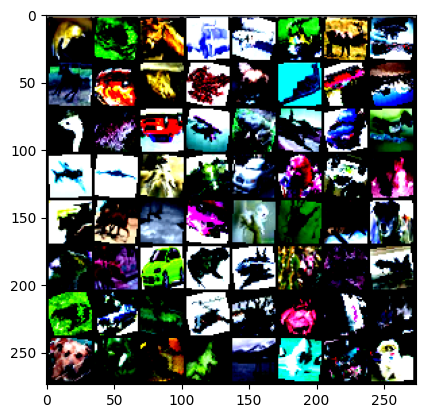

GroundTruth:  cat   frog  horse truck ship  horse deer  ship  horse car   frog  frog  dog   plane car   truck bird  frog  car   plane frog  plane car   plane plane plane deer  horse car   bird  car   cat   horse horse ship  car   dog   bird  plane dog   bird  deer  car   frog  plane deer  frog  plane frog  car   deer  bird  horse frog  truck horse dog   bird  cat   dog   ship  plane car   dog  


In [7]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(64)))

In [8]:
outputs = model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(64)))

Predicted:  cat   frog  horse ship  ship  horse deer  ship  horse car   frog  frog  dog   plane car   truck bird  frog  car   plane frog  plane car   truck plane plane deer  horse car   dog   car   horse cat   horse cat   car   dog   bird  deer  cat   bird  deer  car   frog  plane bird  frog  plane frog  car   deer  bird  horse car   truck horse dog   bird  cat   cat   ship  plane car   dog  


In [9]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 86 %


In [10]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 89.2 %
Accuracy for class: car   is 93.2 %
Accuracy for class: bird  is 82.8 %
Accuracy for class: cat   is 72.0 %
Accuracy for class: deer  is 85.3 %
Accuracy for class: dog   is 74.8 %
Accuracy for class: frog  is 91.1 %
Accuracy for class: horse is 88.8 %
Accuracy for class: ship  is 93.1 %
Accuracy for class: truck is 89.5 %
